## Biophysical branching model

Lingchong You

In this notebook, we leverage Jax in order to perform GPU accelerated simulation of branching model by simulating nutrient diffusion and density-dependent diffusion of cell dispersal.


In [2]:
%reset -f
# Import numerical jax dependencies
import jax
from jax import numpy as jnp
from jax import vmap

# For readability. 
from collections import namedtuple

# Import plotting dependencies
import matplotlib.pyplot as plt
from jax_tqdm import scan_tqdm
from IPython.display import clear_output
import time


### Model description

(This model was partially based on a model formulation initially developed by Nan Luo.)

We have four fields representing nutrient ($N$), producer ($P$), grower ($G$), and surfactant ($S$). The reaction-diffusion equations for each of these fields can be written as follows:

#### 1. **Nutrient ($N$)**

$$
\frac{\partial N}{\partial t} = -b_N f_G (a_P P + a_G G) + D_N \nabla^2 N
$$

where:

$$
f_G = \frac{N}{N + K_N} \left(1 - \frac{C}{C_{\text{max}}}\right), \quad C = P + G
$$

#### 2. **Producer ($P$)**

$$
\frac{\partial P}{\partial t} = a_P f_G P - k_G P + k_P f_T G + \nabla \cdot (D_P \nabla P)
$$

where:

$$
f_T = \frac{K_T^n}{N^n + K_T^n}, \quad D_P = k_D (1 + \text{noise}) S
$$

#### 3. **Grower ($G$)**

$$
\frac{\partial G}{\partial t} = a_G f_G G + k_G P - k_P f_T G + \nabla \cdot (D_G \nabla G)
$$

where:

$$
D_G = k_D (1 + \text{noise}) S
$$

#### 4. **Surfactant ($S$)**

$$
\frac{\partial S}{\partial t} = a_S P f - b_S S + D_S \nabla^2 S
$$

where:

$$
f = f_{QS} f_E f_P, \quad f_{QS} = \frac{C^d}{C^d + K_C^d}, \quad f_E = \frac{K_E^a}{N^a + K_E^a}, \quad f_P = \frac{N^b}{N^b + K_P^b}
$$

### Summary of Dynamics

- **Nutrient ($N$)**: Decreases due to consumption by both producers and growers.
- **Producer ($P$)**: Growth depends on available nutrients, and producers can also decay or get converted into growers.
- **Grower ($G$)**: Grows using nutrients and can be produced from producers.
- **Surfactant ($S$)**: Produced by the producer and decays naturally. The surfactant affects the diffusivity of both the producer and grower fields.

These equations describe a reaction-diffusion system that involves:
- **Diffusion**: Represented by terms involving $\nabla^2$ or $\nabla \cdot (D \nabla U)$.
- **Reaction Terms**: Represented by production, consumption, and conversion interactions involving multiple species and parameters.


### Mathematical Description of numerical operations.

This section provides a mathematical description of the functions implemented in the code, focusing on initializing fields and the numerical operators used for spatial diffusion.

#### 1. **Field Initialization**
The function `initialize_fields(nx, ny, Lx, Ly, N0, C0, R0)` initializes the fields \(N\), \(P\), \(G\), and \(S\) over a 2D grid with dimensions \(nx 	imes ny\). The physical domain has sizes \(L_x\) and \(L_y\).

- **Nutrient Field (\(N\))**: Initialized uniformly across the domain with concentration \(N_0\).
  
  $$
  N(x, y) = N_0, \quad \forall (x, y) \in [0, L_x] \times [0, L_y]
  $$

- **Producer Field (\(P\))**: Initialized as zero throughout the domain.

  $$
  P(x, y) = 0, \quad \forall (x, y) \in [0, L_x] \times [0, L_y]
  $$

- **Grower Field (\(G\))**: Initialized with a Gaussian distribution centered in the domain, with an initial concentration \(C_0\) and standard deviation corresponding to \(R_0\).

  $$
  G(x, y) = C_0 \exp\left(-\frac{(x - L_x/2)^2 + (y - L_y/2)^2}{R_0^2}\right)
  $$

- **Surfactant Field (\(S\))**: Initialized as zero throughout the domain.

  $$
  S(x, y) = 0, \quad \forall (x, y) \in [0, L_x] \times [0, L_y]
  $$

#### 2. **Laplacian Operator**
The function `laplacian(U, dx, dy)` computes the Laplacian of a 2D field \(U\) using central difference approximations. The Laplacian is used to represent the diffusion process and is defined as:

$$
\nabla^2 U = \frac{\partial^2 U}{\partial x^2} + \frac{\partial^2 U}{\partial y^2}
$$

Using finite differences, the Laplacian is approximated as:

$$
\nabla^2 U_{i,j} \approx \frac{U_{i+1,j} - 2U_{i,j} + U_{i-1,j}}{dx^2} + \frac{U_{i,j+1} - 2U_{i,j} + U_{i,j-1}}{dy^2}
$$

#### 3. **Diffusion Operator with Variable Diffusivity**
The function `diffusion_operator(U, D, dx)` computes the diffusion term \(\nabla \cdot (D \nabla U)\) for a 2D field \(U\) with a spatially variable diffusivity \(D\). Neumann boundary conditions (zero-flux) are implemented by padding the field values at the boundaries.

The diffusion operator is given by:

$$
\nabla \cdot (D \nabla U) = D \nabla^2 U + \nabla D \cdot \nabla U
$$

Where:
- **Term 1**: \(D \nabla^2 U\) represents the standard diffusion with diffusivity \(D\).
- **Term 2**: \(\nabla D \cdot \nabla U\) accounts for the spatial variation in diffusivity.

The finite difference approximations for these terms are:

- **Gradient of \(U\)**:

  $$
  \frac{\partial U}{\partial x} \approx \frac{U_{i+1, j} - U_{i-1, j}}{2 dx}, \quad \frac{\partial U}{\partial y} \approx \frac{U_{i, j+1} - U_{i, j-1}}{2 dx}
  $$

- **Gradient of \(D\)**:

  $$
  \frac{\partial D}{\partial x} \approx \frac{D_{i+1, j} - D_{i-1, j}}{2 dx}, \quad \frac{\partial D}{\partial y} \approx \frac{D_{i, j+1} - D_{i, j-1}}{2 dx}
  $$

- **Laplacian of \(U\)**:

  $$
  \nabla^2 U_{i,j} \approx \frac{U_{i+1,j} - 2U_{i,j} + U_{i-1,j}}{dx^2} + \frac{U_{i,j+1} - 2U_{i,j} + U_{i,j-1}}{dx^2}
  $$

The resulting diffusion term is computed as:

$$
\nabla \cdot (D \nabla U) = D \nabla^2 U + \frac{\partial D}{\partial x} \cdot \frac{\partial U}{\partial x} + \frac{\partial D}{\partial y} \cdot \frac{\partial U}{\partial y}
$$

### Summary
- **Field Initialization**: The fields \(N\), \(P\), \(G\), and \(S\) are initialized with specified initial conditions over a 2D domain.
- **Laplacian Operator**: Approximates the second-order spatial derivatives for diffusion.
- **Diffusion with Variable Diffusivity**: Computes the spatial diffusion of a field considering both constant and variable diffusivities, using finite difference methods to approximate gradients and Laplacians.

These operators are used to model the evolution of nutrient, producer, grower, and surfactant fields in a 2D spatial domain with diffusion and reaction dynamics.


In [4]:
import jax
import jax.numpy as jnp
from jax import jit
import matplotlib.pyplot as plt
import os
import numpy as np

def initialize_fields(nx, ny, Lx, Ly, N0, C0, R0):
    """
    Initializes the fields N, P, G, S.
    
    Parameters:
    - nx, ny: Grid dimensions.
    - Lx, Ly: Physical domain sizes.
    - N0: Initial nutrient concentration.
    - C0: Initial cell concentration at the center.
    - R0: Radius for initial cell concentration.
    
    Returns:
    - Tuple of (N_initial, P_initial, G_initial, S_initial)
    """
    x = jnp.linspace(0, Lx, nx, endpoint=False)
    y = jnp.linspace(0, Ly, ny, endpoint=False)
    X, Y = jnp.meshgrid(x, y, indexing='ij')
    
    # Initialize Nutrient N uniformly
    N_initial = jnp.full((nx, ny), N0)
    
    # Initialize P and G
    P_initial = jnp.zeros((nx, ny))
    G_initial = C0 * jnp.exp(-((X - Lx/2)**2 + (Y - Ly/2)**2))
 
     
    # Initialize S as zero
    S_initial = jnp.zeros((nx, ny))
    
    return N_initial, P_initial, G_initial, S_initial

@jit
def laplacian(U, dx, dy):
    """
    Computes the Laplacian of a 2D field using central differences.

    Parameters:
    - U: 2D array.
    - dx, dy: Spatial step sizes.

    Returns:
    - Laplacian of U.
    """
    U_padded = jnp.pad(U, pad_width=1, mode='edge')
    laplacian_U = (
        (U_padded[2:, 1:-1] - 2 * U + U_padded[:-2, 1:-1]) / dx**2 +
        (U_padded[1:-1, 2:] - 2 * U + U_padded[1:-1, :-2]) / dy**2
    )
    return laplacian_U


@jit

def diffusion_operator(U, D, dx):
    """
    Computes the diffusion term ∇·(D ∇U) for a 2D field U with variable diffusivity D,
    implementing Neumann (zero-flux) boundary conditions.

    Parameters:
    - U: 2D array representing the concentration of a species (P or G).
    - D: 2D array representing the diffusivity at each grid point.
    - dx: Spatial step size (assumed equal in x and y).

    Returns:
    - diffusion: 2D array of the same shape as U representing ∇·(D ∇U).
    """
    # Pad U and D with edge values to implement Neumann boundary conditions
    U_padded = jnp.pad(U, pad_width=1, mode='edge')
    D_padded = jnp.pad(D, pad_width=1, mode='edge')

    # Compute finite differences
    # ∇U
    dU_dx = (U_padded[2:, 1:-1] - U_padded[:-2, 1:-1]) / (2 * dx)
    dU_dy = (U_padded[1:-1, 2:] - U_padded[1:-1, :-2]) / (2 * dx)

    # ∇D
    dD_dx = (D_padded[2:, 1:-1] - D_padded[:-2, 1:-1]) / (2 * dx)
    dD_dy = (D_padded[1:-1, 2:] - D_padded[1:-1, :-2]) / (2 * dx)

    # Compute ∇·(D ∇U) = D ∇²U + ∇D · ∇U
    laplacian_U = (U_padded[2:, 1:-1] - 2 * U + U_padded[:-2, 1:-1]) / dx**2 + \
                 (U_padded[1:-1, 2:] - 2 * U + U_padded[1:-1, :-2]) / dx**2

    diffusion = D * laplacian_U + dD_dx * dU_dx + dD_dy * dU_dy

    return diffusion






In [5]:
@jit
def pde_update_fdm(pde_state, pde_params, dx, dy, dt, noise):
    """
    Corrected finite difference update for N, P, G, S with proper ∇·(D * ∇U) diffusion terms
    and Neumann boundary conditions.

    Parameters:
    - pde_state: Tuple of current states (N, P, G, S).
    - pde_params: Tuple of parameters (DN, DS, kD, bN, aG, aP, kG, kP, KN, KT, aS, bS, KE, KC, Cmax, n, d, a, b, KP).
    - dx, dy: Spatial step sizes (assumed equal).
    - dt: Time step size.
    - noise: 2D array of noise to inject into D_eff.

    Returns:
    - Updated state (N_new, P_new, G_new, S_new), None
    """
    N, P, G, S = pde_state
    (DN, DS, kD, bN, aG, aP, kG, kP, KN, KT, aS, bS, KE, KC, Cmax, n, d, a, b, KP) = pde_params

    C = P + G

    # Reaction Terms
    fG = (N / (N + KN)) * (1 - C / Cmax)
    dN = -bN * fG * (aP * P + aG * G)
    fT = (KT ** n) / (N ** n + KT ** n)
    dP = aP * fG * P - kG * P + kP * fT * G
    dG = aG * fG * G + kG * P - kP * fT * G
    fQS = (C ** d) / (C ** d + KC ** d)
    fE = (KE ** a) / (N ** a + KE ** a)
    fP = (N ** b) / (N ** b + KP ** b)
    f = fQS * fE * fP
    dS = aS * P * f - bS * S

    # Compute variable diffusivities
    D_P = kD * (1 + noise) * S
    D_P = jnp.clip(D_P, 0, None)
    D_G = kD * (1 + noise) * S
    D_G = jnp.clip(D_G, 0, None)

    # Compute diffusion terms using the corrected operator with Neumann BC
    diffusion_N = DN * laplacian(N, dx, dy)  # Assuming DN is constant
    diffusion_S = DS * laplacian(S, dx, dy)  # Assuming DS is constant

    diffusion_P = diffusion_operator(P, D_P, dx)
    diffusion_G = diffusion_operator(G, D_G, dx)

    # Update equations using Explicit Euler Scheme
    N_new = N + dt * (dN + diffusion_N)
    P_new = P + dt * (dP + diffusion_P)
    G_new = G + dt * (dG + diffusion_G)
    S_new = S + dt * (dS + diffusion_S)

    # Ensure Non-Negativity
    N_new = jnp.clip(N_new, 0, None)
    P_new = jnp.clip(P_new, 0, None)
    G_new = jnp.clip(G_new, 0, None)
    S_new = jnp.clip(S_new, 0, None)

    return (N_new, P_new, G_new, S_new), None


[8, 0.579, 2000.0, 22, 24.24, 8.67, 75.36, 16.98, 1, 10, 1, 5, 9, 6, 10, 2, 2.205, 1.69, 1.84, 3.21, 50, 0.2]


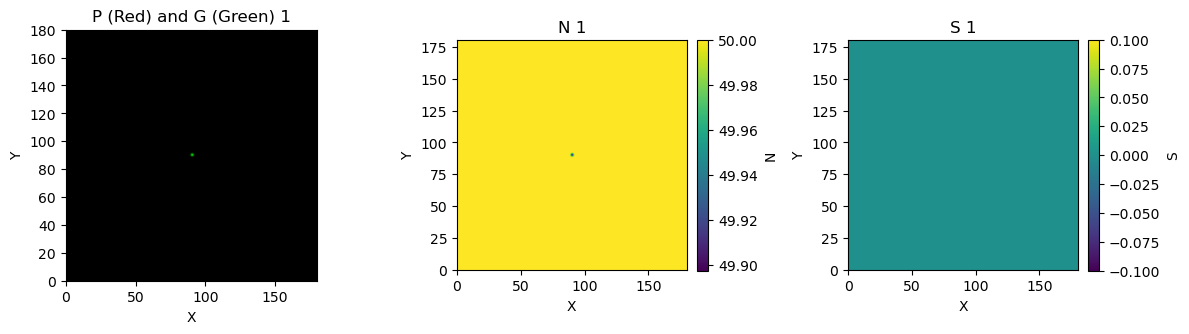

Step 0: Time = 0.0000, Colony Radius = 1.7010


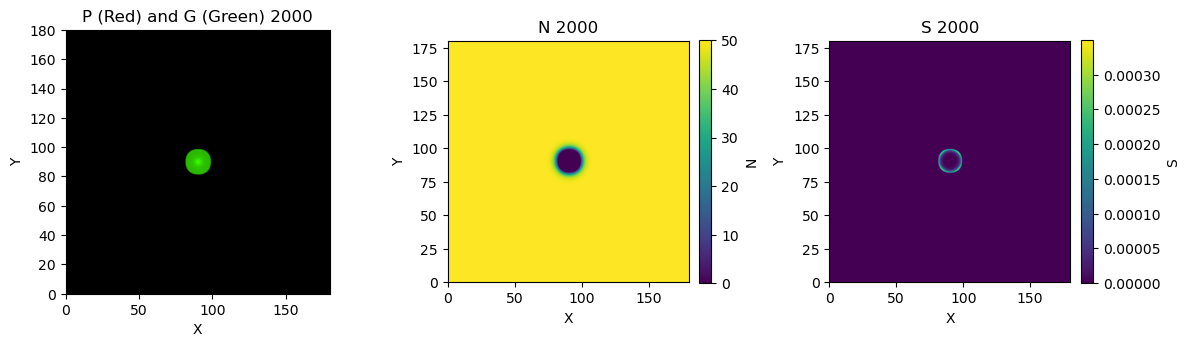

Step 1999: Time = 1.9990, Colony Radius = 9.2737


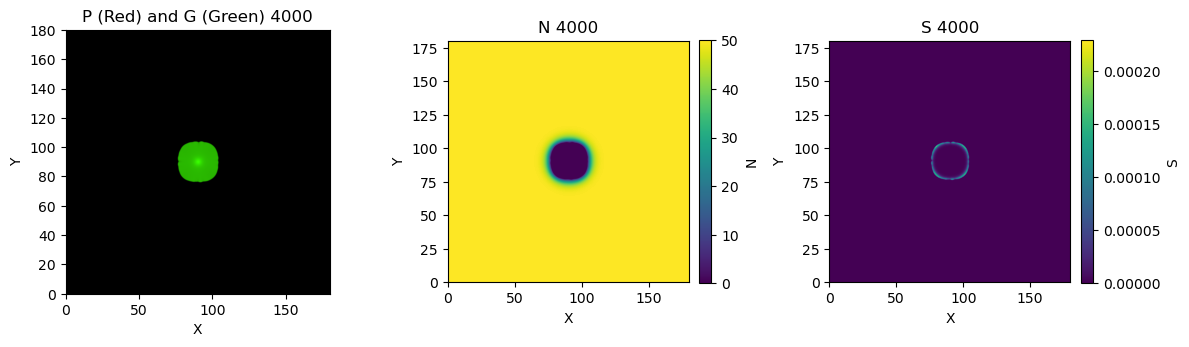

Step 3999: Time = 3.9990, Colony Radius = 14.7758


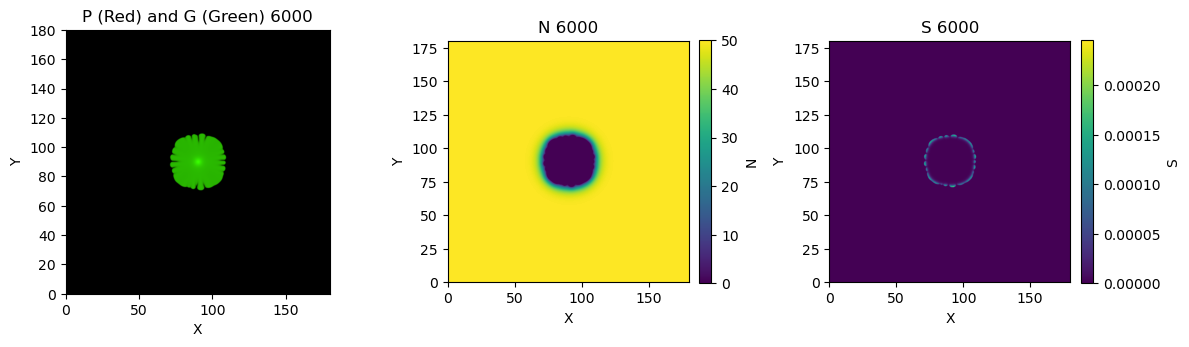

Step 5999: Time = 5.9990, Colony Radius = 19.6826


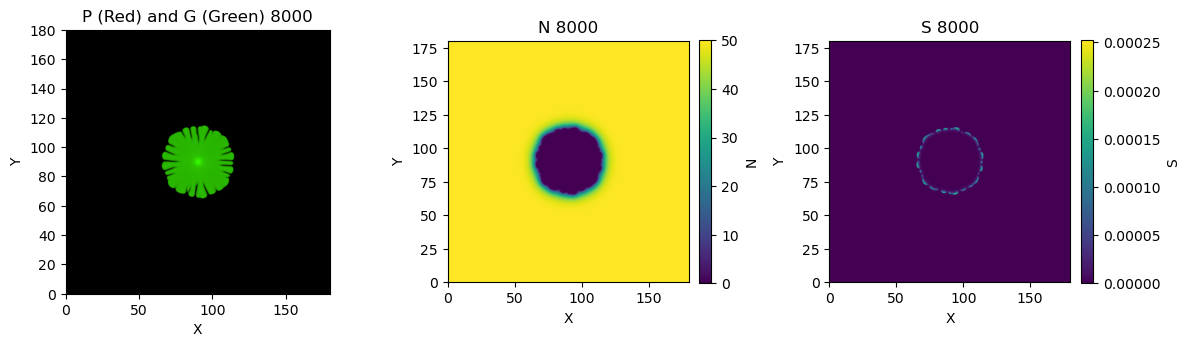

Step 7999: Time = 7.9990, Colony Radius = 24.7410


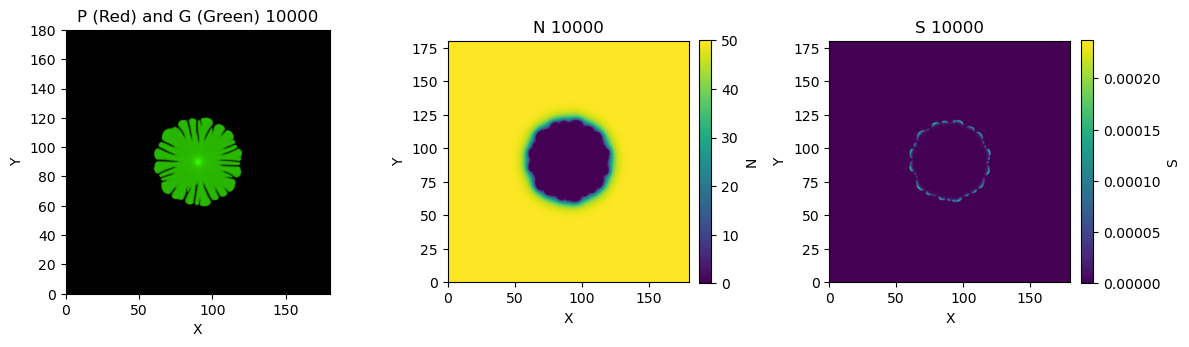

Step 9999: Time = 9.9990, Colony Radius = 29.8353


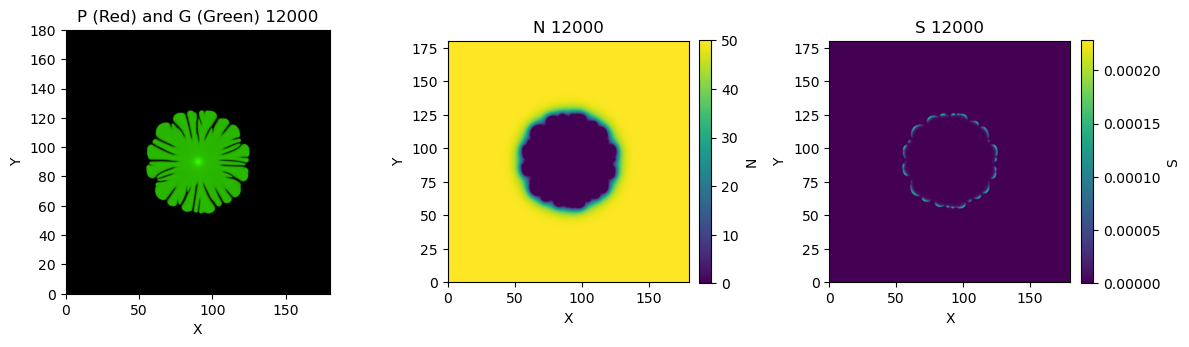

Step 11999: Time = 11.9990, Colony Radius = 34.9297


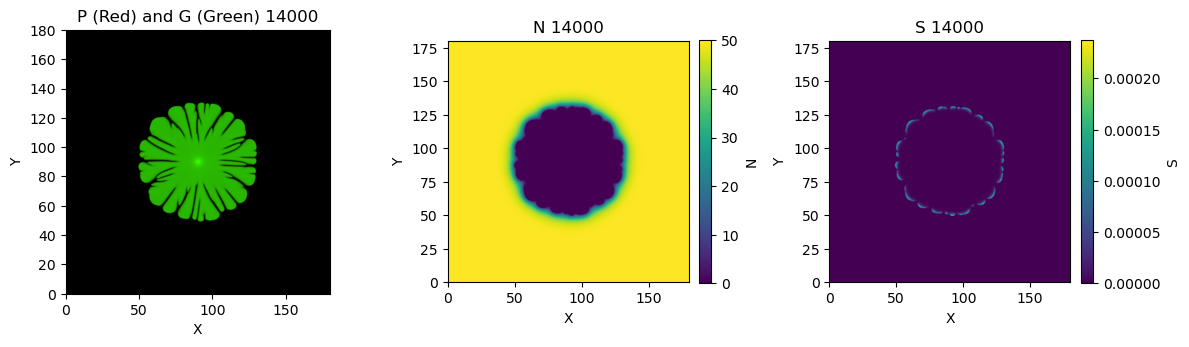

Step 13999: Time = 13.9990, Colony Radius = 40.0320


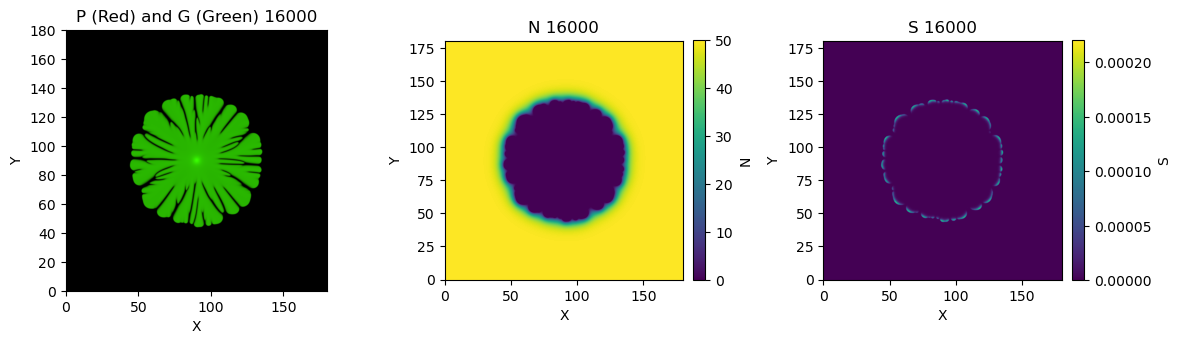

Step 15999: Time = 15.9990, Colony Radius = 45.0554


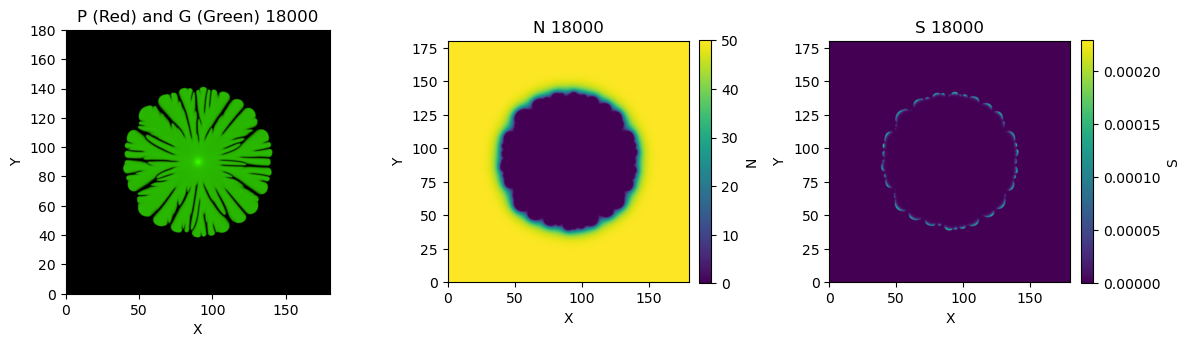

Step 17999: Time = 17.9990, Colony Radius = 50.0454


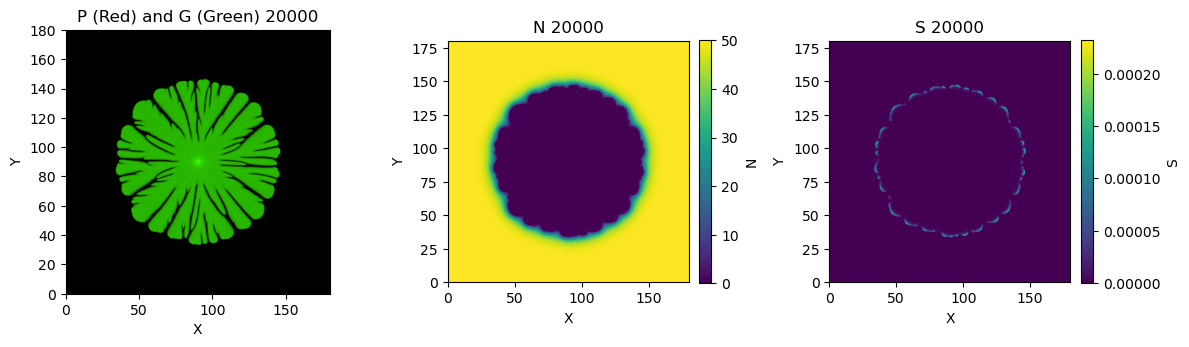

Step 19999: Time = 19.9990, Colony Radius = 55.0553
Simulation completed.


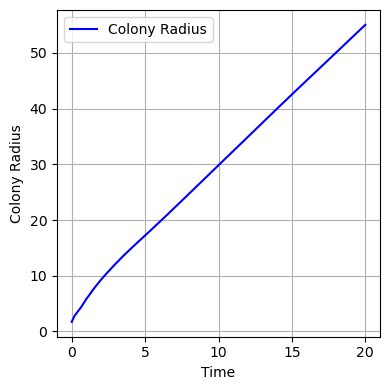

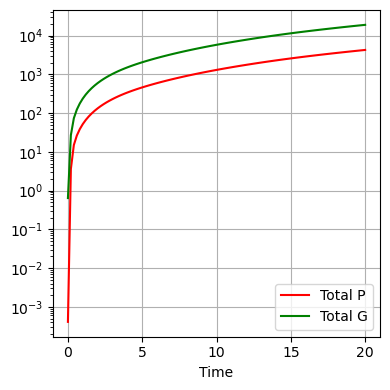

Simulation took 27.20 seconds


In [9]:
import time

#parameters to generate branching
# L = 80
# base parameters (from Nan)
# with modifications aS = 5. 

def run_simulation_fdm():
    """
    Runs the PDE simulation for nutrient concentration (N), proliferating cells (P),
    specialized cells (G), and surfactant (S), using finite difference methods.
    Injects noise into the effective diffusivity D_eff.
    Computes colony area by thresholding C > 0.01 and plots colony radius as a function of time.
    """
    # Define grid parameters
    nx, ny = 600, 600  # Number of grid points (matches MATLAB's nx=401)
    Lx, Ly = 180, 180  # Physical domain size, matching MATLAB's L=20
    dx = Lx / nx
    dy = Ly / ny

    # Define total simulation time and steps
    dt = 1e-3  
    nt = 20000  # Number of time steps
    frames = 10
    samples = 100

    # Define PDE parameters
    # Parameters = [DN, DS, kD, bN, aG, aP, kG, kP, KN, KT, aS, bS, KE, KC, Cmax, n, d, a, b, KP, delta, N0, C0]

    # The parameter values are chosen to reflect the scaled values.
    
    Parameters = [
        8,    #  DN = 1-20 (good results) 
        0.579,    # DS = 5.79
        2e3,    # kP * Cmax, kP=2.58e3
        22,    # bN * Cmax/KN; bN = 15
        24.24,    # aG= 24.24
        8.67,    # aP/aP; aP = 8.67 
        75.36,    # kG = 75.36
        16.98,    # kP = 16.98

        1,   # (fixed. scaling basis for concentrations)

        10,    # KT/KN; KT = 6.45

        1,    #  aS = 1.0 (fixed. basis for time)

        5,    #  bS = 170.52
        9,    # KE/KN; KE = 6.08
        6,    # KC/KN; KC = 4.55

        10,    #Cmax/Cmax; Cmax= 10  (fixed. scaling basis for cell density and surfactant)

        2,    # n_param
        2.205,    # d_param
        1.69,    # a_param
        1.84,    # b_param
        3.21,    # KP/KN; KP = 2.06
        50,    # N0/KN; N0 = 31.5
        0.2     # C0/Cmax; C0 = 1.59
    ]

    # Extract parameters
    DN, DS, kD, bN, aG, aP, kG, kP, KN, KT, aS, bS, KE, KC, Cmax, n, d, a, b, KP, N0, C0 = Parameters

    print(Parameters)
    # Update pde_params tuple
    pde_params = (DN, DS, kD, bN, aG, aP, kG, kP, KN, KT, aS, bS, KE, KC, Cmax, n, d, a, b, KP)

    # Define initial conditions
    R0 = 1.0    # Radius for initial cell concentration, matching MATLAB's exp(- (rr/1)^2 )

    N_initial, P_initial, G_initial, S_initial = initialize_fields(nx, ny, Lx, Ly, N0, C0, R0)
    pde_state = (N_initial, P_initial, G_initial, S_initial)

    # Define noise parameters
    epsilon = 0.2 # Noise amplitude; adjust as needed

    # Initialize PRNG key
    seed = 42  # Arbitrary seed for reproducibility
    key = jax.random.PRNGKey(seed)

    # Initialize lists to store colony radius, time, total P, and total G
    colony_radius_list = []
    time_list = []
    total_P_list = []
    total_G_list = []

    # Define threshold for colony
    C_threshold = 0.01

    # Compute cell area
    cell_area = dx * dy

    # Create directory to save outputs (optional)
    save_dir = 'simulation_outputs_fdm'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Simulation loop
    for step in range(nt):
        # Generate a new random key for this step
        key, subkey = jax.random.split(key)

        # Generate noise: Gaussian noise with mean 0 and standard deviation epsilon
        noise = epsilon * (jax.random.uniform(subkey, shape=(nx, ny)) * 2 - 1)

        # Update PDE state with noise injected into D_eff using FDM
        pde_state, _ = pde_update_fdm(
            pde_state,
            pde_params,
            dx,
            dy,
            dt,
            noise
        )

    
        # Extract updated N, P, G, S
        N, P, G, S = pde_state

        # Compute total cell density C = P + G
        C = P + G

        if (step == 0) or ((step + 1) % (nt//samples) == 0):
            # Compute colony area by thresholding C > C_threshold
            colony_mask = C > C_threshold
            colony_area = jnp.sum(colony_mask) * cell_area

            # Compute colony radius assuming circular colony
            colony_radius = jnp.sqrt(colony_area / jnp.pi)
            colony_radius_list.append(colony_radius)
            time_list.append(step * dt)

            # Compute total P and G across the space
            total_P = jnp.sum(P) * cell_area
            total_G = jnp.sum(G) * cell_area
            total_P_list.append(total_P)
            total_G_list.append(total_G)

        # Optional: Visualization and data saving every 500 steps
        if (step == 0) or ((step+1) % (nt//frames) == 0):
            plt.figure(figsize=(12, 5))

            # Create composite RGB image for P and G
            composite_image = np.zeros((nx, ny, 3))
            composite_image[..., 0] = P  # Red channel for P
            composite_image[..., 1] = G  # Green channel for G
            composite_image = composite_image / composite_image.max()  # Normalize to [0, 1]

            # Plot Composite Image of P and G
            plt.subplot(1, 3, 1)
            plt.imshow(composite_image, extent=(0, Lx, 0, Ly), origin='lower')
            plt.title(f'P (Red) and G (Green) {step + 1}')
            plt.xlabel('X')
            plt.ylabel('Y')

            # Plot N (Nutrient Concentration)
            plt.subplot(1, 3, 2)
            im_n = plt.imshow(N, extent=(0, Lx, 0, Ly), origin='lower', cmap='viridis')
            cbar_n = plt.colorbar(im_n, fraction=0.046, pad=0.04)
            cbar_n.ax.set_ylabel('N')
            plt.title(f'N {step + 1}')
            plt.xlabel('X')
            plt.ylabel('Y')

            # Plot S (Surfactant Concentration)
            plt.subplot(1, 3, 3)
            im_s = plt.imshow(S, extent=(0, Lx, 0, Ly), origin='lower', cmap='viridis')
            cbar_s = plt.colorbar(im_s, fraction=0.046, pad=0.04)
            cbar_s.ax.set_ylabel('S')
            plt.title(f'S {step + 1}')
            plt.xlabel('X')
            plt.ylabel('Y')

            plt.tight_layout()
            plt.show()
            # Optionally, save the plots
            # plt.savefig(os.path.join(save_dir, f'step_{step}.png'))
            # plt.close()

            # Print progress and colony radius
            print(f"Step {step}: Time = {step*dt:.4f}, Colony Radius = {colony_radius:.4f}")

    print("Simulation completed.")

    # Convert lists to NumPy arrays for plotting
    colony_radius_array = jnp.array(colony_radius_list)
    time_array = jnp.array(time_list)
    total_P_array = jnp.array(total_P_list)
    total_G_array = jnp.array(total_G_list)

    # Plot Colony Radius vs Time
    plt.figure(figsize=(4, 4))
    plt.plot(time_array, colony_radius_array, label='Colony Radius', color='blue')
    plt.xlabel('Time')
    plt.ylabel('Colony Radius')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # Optionally, save the plot
    # plt.savefig(os.path.join(save_dir, 'colony_radius_vs_time_fdm.png'))

    # Plot Total P and G vs Time (log scale for y-axis)
    plt.figure(figsize=(4, 4))
    plt.plot(time_array, total_P_array, label='Total P', color='red')
    plt.plot(time_array, total_G_array, label='Total G', color='green')
    plt.xlabel('Time')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # Optionally, save the plot
    # plt.savefig(os.path.join(save_dir, 'total_P_G_vs_time_fdm.png'))

start = time.time()
run_simulation_fdm()
end = time.time()
print(f"Simulation took {end - start:.2f} seconds")
